In [43]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt 

In [44]:
class Value:

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)
                          ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [45]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [154]:
# define Value objects and see how it works
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

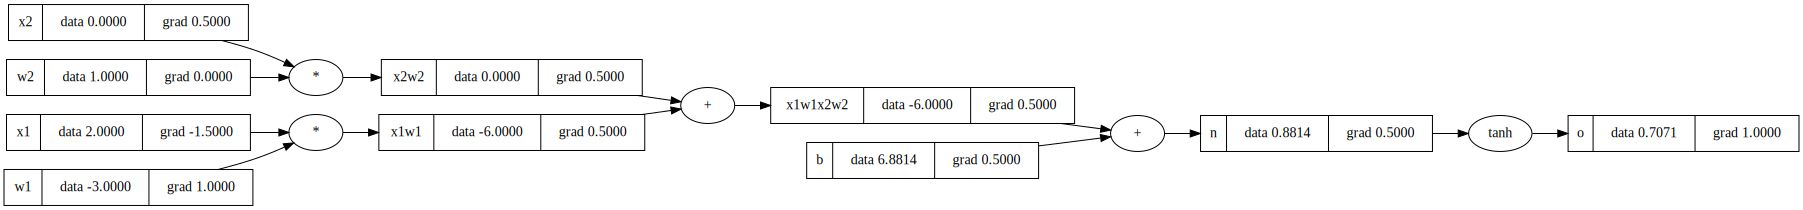

In [155]:
# o.grad = 1      # base case
# o._backward()   # o = tanh(n); do/dn = dtanh(n)/dn * do/do
# n._backward()   # just transfer n.grad to b and x1w1x2w2 because it is '+' operation
# ...

# or call backward on root node - use topological sort 
# to call _backward on each node in reverse topo sort
o.backward()
draw_dot(o)

In [179]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [166]:
# n = Neuron(2)
# n([2.0, 3.0])    # one neuron call

# l = Layer(2, 3)
# l([2.0, 3.0])    # one layer call

# mlp = MLP(2, [2,3,1])
# mlp([2.0, 3.0])    # mlp call
# mlp.parameters()
# mlp.layers[1].neurons[0].w[0].grad  # some specific weight grad


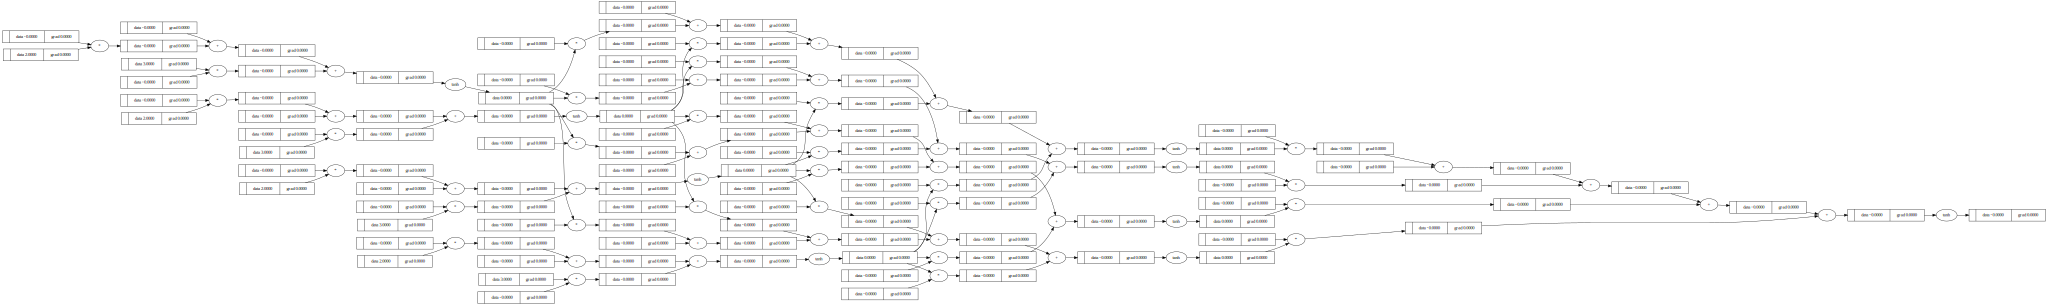

In [200]:
draw_dot(mlp([2.0, 3.0]))

### Examples

In [160]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
mlp = MLP(3, [4, 4, 1])

In [161]:
for k in range(20):
    y_preds = [mlp(x) for x in xs]
    loss = sum((y_pred - y)**2 for y_pred, y in zip (y_preds, ys))

    for p in mlp.parameters():
        p.grad = 0.0

    loss.backward()
    for p in mlp.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 3.9586118683368863
1 2.689675820041409
2 2.4154389991747642
3 2.1853181773708106
4 1.915643771424782
5 2.7190400957075402
6 0.6179028562492535
7 0.328988426905457
8 0.1624924756059608
9 0.11185408236806742
10 0.08635988745369773
11 0.07011957738679225
12 0.05890975045421533
13 0.05072572775719183
14 0.04449818152777734
15 0.039606202956475246
16 0.03566524308526812
17 0.03242475275454539
18 0.02971466953294797
19 0.027415599943087864


In [211]:
def loss(model, X, Y, batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, Y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], Y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


def optimization(model, X, Y, epochs):
    for k in range(epochs):
        
        # forward
        total_loss, acc = loss(model, X, Y, 24)

        # backward
        for p in model.parameters():
            p.grad = 0.0
        total_loss.backward()
        
        # update (sgd)
        # learning_rate = 1.0 - 0.9*k/100
        learning_rate = 0.05
        for p in model.parameters():
            p.data -= learning_rate * p.grad
        
        if k % 5 == 0:
            print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


def visualize_decision_boundary(model, X, Y): 
    xx, yy = np.meshgrid(np.arange(-1.5, 2.5, 0.1),
                         np.arange(-1.5, 2, 0.1))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

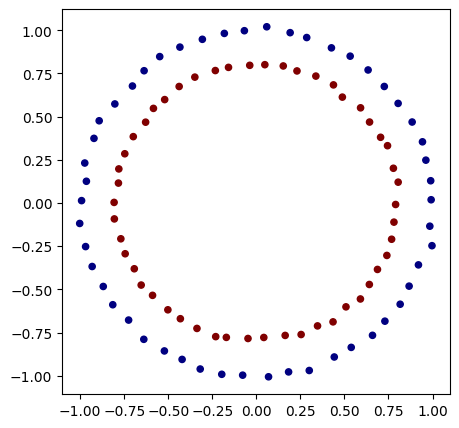

In [306]:
from sklearn.datasets import make_circles

X, Y = make_circles(n_samples=100, noise=0.01)
Y = Y*2 - 1 # make y be -1 or 1

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y, s=20, cmap='jet')

In [215]:
# initialize a model 
model = MLP(2, [32, 32, 1]) # 2-layer neural network
optimization(model, X, Y, epochs=350)

step 0 loss 0.7952569012628298, accuracy 66.66666666666666%
step 5 loss 0.9321167446205658, accuracy 58.333333333333336%
step 10 loss 1.1321449344200591, accuracy 45.83333333333333%
step 15 loss 0.9982062906090846, accuracy 50.0%
step 20 loss 0.9654408156624338, accuracy 50.0%
step 25 loss 1.1044865274865738, accuracy 45.83333333333333%
step 30 loss 0.8931198844662267, accuracy 58.333333333333336%
step 35 loss 1.3601977079428311, accuracy 33.33333333333333%
step 40 loss 0.9156308145514432, accuracy 50.0%
step 45 loss 1.0444024570758255, accuracy 50.0%
step 50 loss 1.0106226125135789, accuracy 54.166666666666664%
step 55 loss 1.0322954424582447, accuracy 58.333333333333336%
step 60 loss 0.8623103116939239, accuracy 62.5%
step 65 loss 0.7863660270981837, accuracy 75.0%
step 70 loss 1.177411824821355, accuracy 45.83333333333333%
step 75 loss 0.9977147248193727, accuracy 62.5%
step 80 loss 0.8575182620196483, accuracy 70.83333333333334%
step 85 loss 0.9585342606356835, accuracy 62.5%
step 

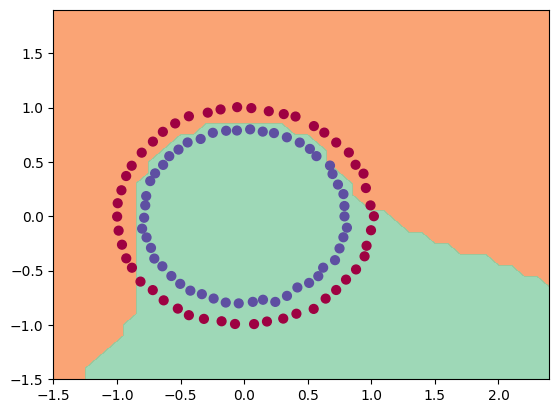

In [216]:
visualize_decision_boundary(model, X, Y)

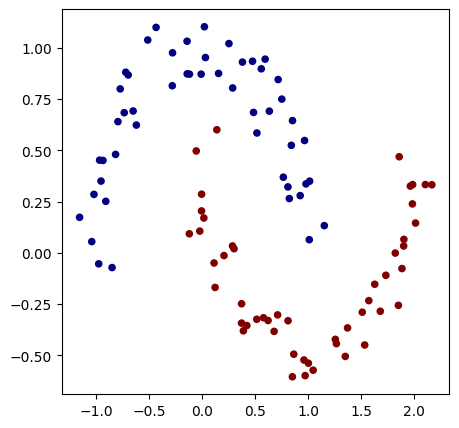

In [268]:
from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=100, noise=0.1)
Y = Y*2 - 1 # make y be -1 or 1

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y, s=20, cmap='jet')

In [197]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
optimization(model, X, Y, epochs=50)

step 0 loss 1.289303289745938, accuracy 24.0%
step 5 loss 0.3105155555340456, accuracy 86.0%
step 10 loss 0.26507984492647924, accuracy 88.0%
step 15 loss 0.2342404539128518, accuracy 91.0%
step 20 loss 0.20741076364253802, accuracy 93.0%
step 25 loss 0.16803547725540394, accuracy 93.0%
step 30 loss 0.12090468093409441, accuracy 96.0%
step 35 loss 0.10218928017119082, accuracy 98.0%
step 40 loss 0.09083251883564127, accuracy 98.0%
step 45 loss 0.07655939381338227, accuracy 98.0%


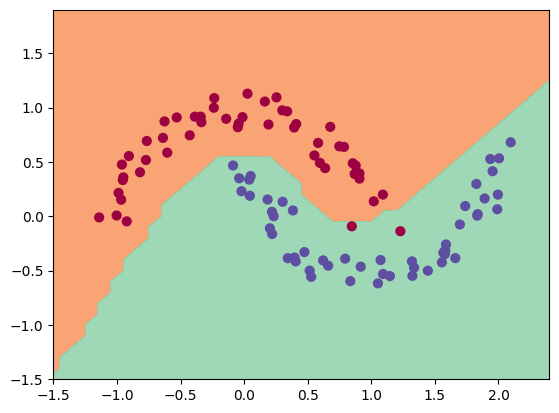

In [198]:
visualize_decision_boundary(model, X, Y)

### Done with circles using pytorch

In [307]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.Linear(hidden_sizes[0], hidden_sizes[1]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[1], output_size))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Convert data to PyTorch tensors
points_tensor = torch.from_numpy(X).float()
labels_tensor = torch.from_numpy(Y).float().unsqueeze(1)

# Define the MLP model with appropriate input and output sizes
input_size = 2  # Dimension of input points
hidden_sizes = [32, 32]  # Number of neurons in each hidden layer
output_size = 1  # Number of output neurons (binary classification)
model = MLP(input_size, hidden_sizes, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 5000
batch_size = 100
num_batches = len(X) // batch_size

for epoch in range(num_epochs):
    for batch in range(num_batches):
        # Get the current batch of data
        batch_start = batch * batch_size
        batch_end = (batch + 1) * batch_size
        batch_points = points_tensor[batch_start:batch_end]
        batch_labels = labels_tensor[batch_start:batch_end]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_points)

        # Compute the loss
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/5000, Loss: 0.785734236240387
Epoch 2/5000, Loss: 0.7212938070297241
Epoch 3/5000, Loss: 0.6602418422698975
Epoch 4/5000, Loss: 0.6018804907798767
Epoch 5/5000, Loss: 0.5462261438369751
Epoch 6/5000, Loss: 0.4923689365386963
Epoch 7/5000, Loss: 0.43997231125831604
Epoch 8/5000, Loss: 0.3897406756877899
Epoch 9/5000, Loss: 0.3414864242076874
Epoch 10/5000, Loss: 0.2959345579147339
Epoch 11/5000, Loss: 0.25298166275024414
Epoch 12/5000, Loss: 0.21277885138988495
Epoch 13/5000, Loss: 0.17564310133457184
Epoch 14/5000, Loss: 0.14197728037834167
Epoch 15/5000, Loss: 0.11192575097084045
Epoch 16/5000, Loss: 0.08566658198833466
Epoch 17/5000, Loss: 0.06274831295013428
Epoch 18/5000, Loss: 0.04273419454693794
Epoch 19/5000, Loss: 0.025261154398322105
Epoch 20/5000, Loss: 0.01001304667443037
Epoch 21/5000, Loss: -0.0034634398762136698
Epoch 22/5000, Loss: -0.01555925328284502
Epoch 23/5000, Loss: -0.02660592645406723
Epoch 24/5000, Loss: -0.036843203008174896
Epoch 25/5000, Loss: -0.046

In [308]:
predictions = model(points_tensor)
predictions = (predictions > 0).squeeze().detach().numpy().astype(int)

(-1.5, 1.900000000000003)

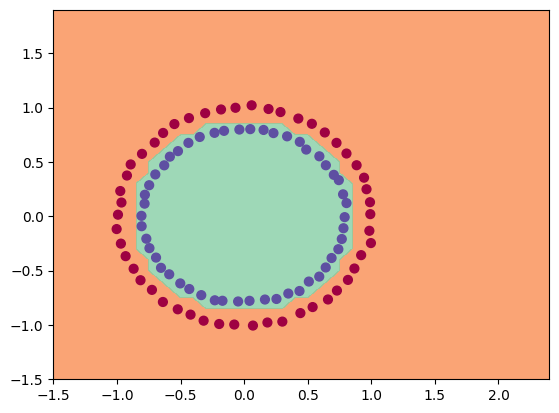

In [309]:
# visualize decision boundary
xx, yy = np.meshgrid(np.arange(-1.5, 2.5, 0.1),
                     np.arange(-1.5, 2, 0.1))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
Xmesh = torch.from_numpy(Xmesh).float()
scores = model(Xmesh)
Z = np.array([s.data > 0.0001 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())